In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,344.493128,18.131217,43.529072,19
RAG Project,521.940117,32.621257,101.658525,16
Azure AD Authentication,709.861716,54.604747,161.945929,13
Azure Functions + Visual Studio,768.595076,59.122698,273.660076,13
Email Auth and Security,830.217915,69.184826,169.888665,12
Audit Report Tracker (Sharepoint List),831.247592,75.567963,250.749548,11
WSL + Kali Linux,1087.514106,77.679579,359.428193,14
Azure DevOps Pipelines,1136.643741,43.717067,90.599342,26
Debugging in VS Code,1270.319513,70.573306,280.860559,18
Terraform,1385.299316,57.720805,323.119803,24


# Histogram

sum of ages: ~44474.34


<Axes: >

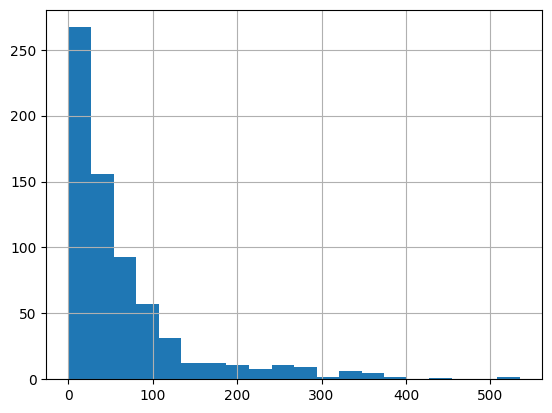

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 685
Total card age: 44474.34


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
1,Azure Developer Associate,Which Azure Monitor API lets you ingest custom...,ba1c9c8d01c752949032f768bd54b51c,-530.700350,60.137193,530.70035,-5292.072983,0.117595,0,0
21,Azure Developer Associate,Front: What guarantee does Session consistency...,a11c64c5adcf3b052574c772bcb35b9e,-290.056526,60.137193,530.70035,-5292.072983,0.117595,3,0
55,Azure Developer Associate,Name three built-in Azure Monitor Log Analytic...,77d0ef104ea7d214ad0191832bd85145,-201.378149,60.137193,530.70035,-5292.072983,0.117595,6,0
90,Azure Developer Associate,Front: What’s the max data size and RU/s throu...,639068699ab1e50763566d77b001137a,-130.346474,60.137193,530.70035,-5292.072983,0.117595,9,0
114,Azure Developer Associate,What Azure Monitor portal tool lets you chart ...,e70688e3e78d49d337aa3004b1e0a7e4,-109.831490,60.137193,530.70035,-5292.072983,0.117595,12,0
139,Azure Developer Associate,Front: What’s a good pattern to avoid cross-pa...,695d76cca7d2a0305490f0d5f0964a84,-95.436769,60.137193,530.70035,-5292.072983,0.117595,15,0
157,Azure Developer Associate,There are two options for rehydrating a blob t...,2bed77247f6c9899c6f82087ea372244,-85.930283,60.137193,530.70035,-5292.072983,0.117595,18,0
190,Azure Developer Associate,Front: List three criteria for choosing a good...,628da0612909aa18927ca5adc6332750,-76.663799,60.137193,530.70035,-5292.072983,0.117595,21,0
218,Azure Developer Associate,Front: Why might you choose Serverless over Au...,c48aa43885f657633646e8fb38a68bed,-65.530599,60.137193,530.70035,-5292.072983,0.117595,24,0
239,Azure Developer Associate,What Azure App Service feature allows gradual ...,2db893416fedefb2e7e1b2fa459a0914,-59.584813,60.137193,530.70035,-5292.072983,0.117595,27,0


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,-534.541308,95.533794,534.541308,-2101.743476,0.427736,0,0
1,Azure Developer Associate,Which Azure Monitor API lets you ingest custom...,ba1c9c8d01c752949032f768bd54b51c,-530.700350,60.137193,530.700350,-5292.072983,0.117595,0,0
2,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-440.756222,48.445166,440.756222,-4311.619781,0.439446,0,0
3,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-399.621542,65.186134,399.621542,-4628.215515,0.900956,0,0
4,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-391.797791,88.331660,391.797791,-3886.593055,0.007585,0,0
5,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-359.428193,77.679579,359.428193,-1087.514106,0.146604,0,0
8,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-354.005709,88.331660,391.797791,-3886.593055,0.007585,1,1
6,Open Source/GitHub,Downstream Repository\n\nA fork or clone of an...,31f044e0e9f013c3f84452e9d3446f43,-353.476878,107.976510,353.476878,-1727.624157,0.385778,0,0
7,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-351.674099,65.186134,399.621542,-4628.215515,0.900956,1,1
9,Python,Q:\nWhich library is suggested for adding a pr...,20a08b1267d9ba7eb7b53e276cfdcc4c,-348.392226,91.864295,348.392226,-4317.621888,0.697358,0,0


In [18]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which Azure Monitor API lets you ingest custom...
hash                   ba1c9c8d01c752949032f768bd54b51ca11c64c5adcf3b...
age                                                         -1645.459253
subject_mean_age                                               601.37193
subject_highest_age                                          5307.003502
subject_age_sum                                            -52920.729828
head_random_roll                                                1.175953
count                                                                135
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

-64.92603763637383